# Development of Crash Modification Factors for Rumble Strips Treatments on Rural Two-lane Roads

PREPARED FOR:	Illinois Department of Transportation

COPY TO:	Project Files

PREPARED BY:	CH2M  HILL – Chicago

DATE:	March 16, 2018

REVISION NO.:	Draft

The purpose of this notebook is to document the step by step process leading to CMF calculations for rumble strips treatment.

In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'C:\Users\MR068144\Downloads\Python Scripts'
# importing required packages
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
from datetime import datetime
from shutil import copyfile
from time import gmtime, strftime
from ipywidgets import FloatProgress
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-09-11 08:12:46


In [2]:
# Parameter Definitions
# Analysis Years
Years = range(2005,2017)

# Project Folders and GDBs
Project_DIR = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\3.Evaluation'
Project_GDB = Project_DIR + '\\2.RS_GDB.gdb'
Project_Output = Project_DIR + '\\3.Python_Notebook'

# Roadway and Crash Data
IRISPath = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\5.0_Roadway_Layer\IRIS'
IRISPath = r'C:\Users\mr068144\Downloads\IRIS\IL_IRIS.gdb'
IRIS_Route = {y:os.path.join(IRISPath,'HWY'+str(y)+'_route') for y in Years}
IRIS_Table = {y:os.path.join(IRISPath,'HWY'+str(y)+'_table_HCurve') for y in Years}
CrashPath = r'C:\Users\mr068144\Downloads\IL Crash Data\IL_Crash.gdb'
CrashData = {y:CrashPath + '\\CrashExtract_' + str(y) + '_GIS' for y in Years}
Fields = ['AADT','O_SHD1_TYP','O_SHD1_WTH','O_SHD2_TYP','O_SHD2_WTH','LN_WTH','Radius','CurveLen']
RouteID = 'INVENTORY'
BMP = 'BEG_STA'
EMP = 'END_STA'

# Project Features
RS_Contracts = Project_GDB + '\\RS_Cont_Loc'
Selected_Sites = Project_GDB + '\\Selected_Sites_RS_Data'
Verified_Sites = Project_GDB + '\\Verified_Sites'


This will copy the curent notebook to the project directory

In [13]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [18]:
# Copy Current Notebook to Project Folder
print(strftime("%Y-%m-%d %H:%M:%S"))
from distutils.dir_util import copy_tree
curent_nb = os.path.join(os.getcwd(), nb_name)
shutil.copyfile(curent_nb,os.path.join(Project_Output,nb_name))
l = copy_tree(HSMPY_PATH+'\\hsmpy', Project_Output+'\\hsmpy')

2018-08-03 08:39:28


# 1- Importing Results from Previous Data Collection Project

 In this study the data collected in Rumble Strips Data Collection Project is used which has been documented at the following memo:

\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\Data Collection\Rumble Strip Data Collection Tech Memo.docx

Using the data provided in Rumble Strips Data Collection Project a shapefile is prepared which includes the location information of all the contracts that involved the installation of rumble strips including their bid date and contract numbers. This shapefile is saved in the following location:

\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\Evaluation\RS_Evaluation_GIS_Data.gdb\RS_Cont_Loc

A summary of this shapefile, including the Peergroup distribution and construction year distribution of the contract locations is provided in the following cell:

List of datasets in the \\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\3.Evaluation\2.RS_GDB.gdb:

RS_Cont_Loc
Selected_Sites_RS_Data
Verified_Sites
Sites_2005
Sites_2006
Sites_2007
Sites_2008
Sites_2009
Sites_2010
Sites_2011
Sites_2012
Sites_2013
Sites_2014
Sites_2015
Sites_2016
Crash_2005
Crash_2006
Crash_2007
Crash_2008
Crash_2009
Crash_2010
Crash_2011
Crash_2012
Crash_2013
Crash_2014
Crash_2015
Crash_2016
SitesSummary_All
Sites_Summary
AllCrashes_Before
AllCrashes_After

Contract Locations:


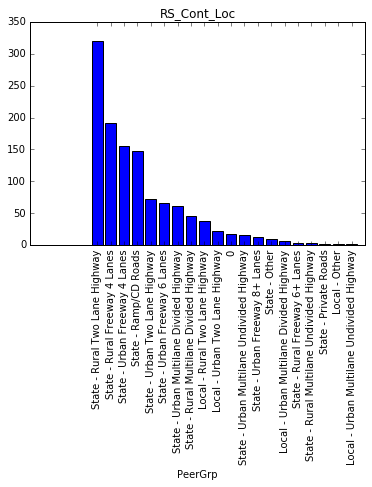

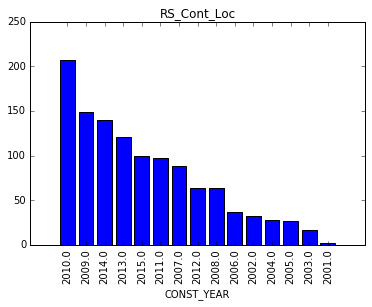

Total Contracts Mileage 4040.76
Total R2U Mileage 1348.19
Total R2U Mileage 2007:2014 819.30


In [7]:
# Summary stats of GDB and contracts
print('List of datasets in the {}:\n'.format(Project_GDB))
print '\n'.join([datasets for root, dirs, datasets in arcpy.da.Walk(Project_GDB)][0])
print('')

print('Contract Locations:')
ssum = hsmpy.common.PrintSummary(RS_Contracts,'')
psum = hsmpy.common.FieldSummary(RS_Contracts,'PeerGrp')
ysum = hsmpy.common.FieldSummary(RS_Contracts,'CONST_YEAR')

print('Total Contracts Mileage {:0.2f}'.format(sum([r.getValue('Shape').length 
                                          for r in arcpy.SearchCursor(RS_Contracts)])/5280))
print('Total R2U Mileage {:0.2f}'.format(sum([r.getValue('Shape').length 
                                              for r in arcpy.SearchCursor(RS_Contracts) 
                                              if r.getValue('PeerGrp') == 'State - Rural Two Lane Highway'])/5280))
print('Total R2U Mileage 2007:2014 {:0.2f}'.format(sum([r.getValue('Shape').length 
                                              for r in arcpy.SearchCursor(RS_Contracts) 
                                              if (r.getValue('PeerGrp') == 'State - Rural Two Lane Highway' 
                                                        and r.getValue('CONST_YEAR') in range(2007,2014))])/5280))

In [7]:
#adf = hsmpy.common.AttributeTabletoDF(Project_GDB+'\\AllCrashes_After')
#bdf = hsmpy.common.AttributeTabletoDF(Project_GDB+'\\AllCrashes_Before')
display(pd.DataFrame(bdf.Type_of_crash.value_counts()))
display(pd.DataFrame(adf.Type_of_crash.value_counts()))
display(pd.DataFrame(bdf.Crash_injury_severity.value_counts()))
display(pd.DataFrame(adf.Crash_injury_severity.value_counts()))
display(pd.DataFrame(bdf[bdf.Crash_injury_severity.isin(['Fatal Crash','A Injury Crash','B Injury Crash'])]['Type_of_crash'].value_counts()))
display(pd.DataFrame(adf[adf.Crash_injury_severity.isin(['Fatal Crash','A Injury Crash','B Injury Crash'])]['Type_of_crash'].value_counts()))



,Type_of_crash
animal,282
fixed object,109
overturned,43
rear end,38
sideswipe opposite direction,26
turning,14
other non collision,13
head on,13
other object,7
angle,4


,Type_of_crash
animal,220
fixed object,58
rear end,38
overturned,17
other object,12
other non collision,12
head on,11
sideswipe opposite direction,9
turning,7
sideswipe same direction,7


,Crash_injury_severity
No Injuries,438
B Injury Crash,57
A Injury Crash,43
Fatal Crash,11
C Injury Crash,8


,Crash_injury_severity
No Injuries,337
B Injury Crash,30
C Injury Crash,13
A Injury Crash,11
Fatal Crash,6


,Type_of_crash
fixed object,35
overturned,28
sideswipe opposite direction,14
head on,10
animal,7
rear end,6
turning,4
parked motor vehicle,2
other non collision,2
other object,2


,Type_of_crash
fixed object,13
head on,8
animal,7
overturned,6
rear end,6
sideswipe opposite direction,2
pedestrian,2
sideswipe same direction,1
turning,1
other object,1


# 2 - Site Selection and Verification:

In this part, using RS_Cont_Loc, the appropriate segments for rumble strip evaluation are selected. Given that most of the segments are rural two-lane two-way roads (R2U), RS_Cont_Loc is filtered for only R2U roads. 

Then R2U segments are overlayed with intersections and 250 feet buffers are excluded from the segments. Given the available crash data is 2004 to 2016 only contracts that have been from 2007 to 2014 are selected, to make sure that we have 3 years of data for before after periods.

The results are saved in the Selected_Sites

Then, Google Street View history is used to collcet the following information:

1) The year of latest street view image without rumble strips ("Last_Off")

2) The year of earliest street view image with rumble strips ("First_On")

3) Presence and type of centerline rumble strips ("Cen_RS")(0: not present, 1: continous)

4) Presence and type of shoulder rumble strips ("Sh_RS")(0: not present, 1: continous, 2: only one side, 3: both sides with gaps)

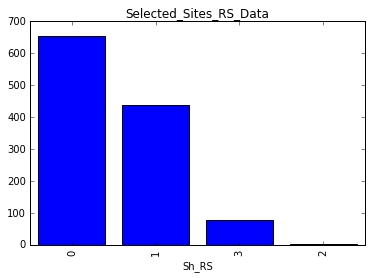

Total Selected Mileage 533.75


In [70]:
# Summary Stats of Selected Sites
ssum = hsmpy.common.PrintSummary(Selected_Sites,'')
psum = hsmpy.common.FieldSummary(Selected_Sites,'Sh_RS')
print('Total Selected Mileage {:0.2f}'.format(sum([r.getValue('Shape').length 
                                          for r in arcpy.SearchCursor(Selected_Sites)])/5280))

Selected Sites are filtered for segments that had both "Last_Off" and "First_On" data and "Sh_RS" = 1. The results are saved in Verified_Sites.

In [72]:
# Summary Stats of Verified Sites
ssum = hsmpy.common.PrintSummary(Verified_Sites,'')
print('Total Verified Mileage {:0.2f}'.format(sum([r.getValue('Shape').length 
                                          for r in arcpy.SearchCursor(Verified_Sites)])/5280))

Total Verified Mileage 202.71


# 3- Roadway Data

Roadway data including AADT, Lane width, Shoulder Type, Shoulder Width is imported from IRIS datasets that were obtained from IDOT website for 2004 to 2016:

http://apps.dot.illinois.gov/gist2/gisdata/all20XX.zip

The downloaded IRIS data is used to find the attributes for verified segments using the following code. The results are saved in the following:

\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\Evaluation\RS_Evaluation_GIS_Data.gdb\Sites20XX

In [ ]:
# Creating Site Routes based on IRIS and dissolving attributes, Without Subprocess
XY_Tolerance = "50 Feet"
RoadwayData = {}
#IRIS_Route = {y:os.path.join(IRISPath,'HWY'+str(y)+'_route.shp') for y in Years}
#IRIS_Table = {y:os.path.join(IRISPath,'HWY'+str(y)+'_table.dbf') for y in Years}
#IRISPath_tab = r'C:\Users\mr068144\Downloads\Curvature'
#IRIS_Table   = {y:os.path.join(IRISPath_tab,'Curves_' + str(y) + '.mdb\\HWY'+str(y)+'_table_HCurve') for y in Years}
#IRIS_Table[2012] = IRIS_Table[2013]
for year in Years:
    # Creating Routes from Verified Sites based on IRIS
    RoadwayData.update({year:hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_GDB,'Sites'),appendix=str(year),Extension='')})
    hsmpy.network.ImportRoadwayData(Verified_Sites,IRIS_Route[year],IRIS_Table[year],Fields,RoadwayData[year],
                                    RouteID,BMP,EMP,XY_Tolerance)
    hsmpy.network.PrintSegSummary(RoadwayData[year],year)

In [9]:
# Creating Site Routes based on IRIS and dissolving attributes, With Subprocess - part 1
XY_Tolerance = "50 Feet"
IRIS_Route = {y:os.path.join(IRISPath,'HWY'+str(y)+'_route.shp') for y in Years}
IRIS_Table = {y:os.path.join(IRISPath,'HWY'+str(y)+'_table.dbf') for y in Years}
IRISPath_tab = r'C:\Users\mr068144\Downloads\Curvature'
IRIS_Table   = {y:os.path.join(IRISPath_tab,'Curves_' + str(y) + '.mdb\\HWY'+str(y)+'_table_HCurve') for y in Years}
IRIS_Table[2012] = IRIS_Table[2013]
SubProcess = []
for year in Years:
    # Creating Routes from Verified Sites based on IRIS
    MDB = os.path.join(Project_Output, 'Sites_' + str(year) + '.mdb')
    try: os.remove(MDB)
    except: pass
    try: arcpy.CreatePersonalGDB_management(out_folder_path=Project_Output,out_name='Sites_' + str(year) + '.mdb')
    except: pass   
    Sites = MDB + '\\Sites_' + str(year)
    arcpy.Delete_management(Sites)
    SubProcess.append(
        hsmpy.network.CON_ImportRoadwayData(Project_Output,
                                            HSMPY_PATH,
                                            Verified_Sites,
                                            IRIS_Route[year],
                                            IRIS_Table[year],
                                            Fields,Sites,RouteID,BMP,EMP,XY_Tolerance)
    )

In [10]:
# Creating Site Routes based on IRIS and dissolving attributes, With Subprocess - part 2
#w = [p.wait() for p in SubProcess]
#print(w)
RoadwayData = {}
for year in Years:
    MDB = os.path.join(Project_Output, 'Sites_' + str(year) + '.mdb')
    Sites = MDB + '\\Sites_' + str(year)
    RoadwayData.update({year:hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_GDB,'Sites'),appendix=str(year),Extension='')})
    arcpy.FeatureClassToFeatureClass_conversion(Sites, Project_GDB, os.path.basename(RoadwayData[year]))
    hsmpy.network.PrintSegSummary(RoadwayData[year],year)

2005: Total Segments: 516, Mileage: 194.47, Average AADT 4123.00
2006: Total Segments: 516, Mileage: 194.58, Average AADT 4102.00
2007: Total Segments: 483, Mileage: 195.67, Average AADT 3926.00
2008: Total Segments: 476, Mileage: 195.62, Average AADT 3903.00
2009: Total Segments: 475, Mileage: 195.60, Average AADT 3794.00
2010: Total Segments: 445, Mileage: 203.29, Average AADT 3917.64
2011: Total Segments: 429, Mileage: 196.28, Average AADT 3929.72
2012: Total Segments: 450, Mileage: 196.33, Average AADT 3830.11
2013: Total Segments: 451, Mileage: 196.44, Average AADT 3827.38
2014: Total Segments: 484, Mileage: 195.31, Average AADT 3841.22
2015: Total Segments: 484, Mileage: 195.40, Average AADT 3761.88
2016: Total Segments: 485, Mileage: 195.41, Average AADT 3746.49


# 4- Observed Crashes:

Observed crashes for 2004 to 2016 are obtained by spatial join between verified sites and crash data. Crashes that were assigned to verified sites are saved in the following shapefiles:

\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\Evaluation\RS_Evaluation_GIS_Data.gdb\Crash20XX

In [27]:
# Adding Observed Crashes to Sites
def CrashType(Row):
    ct = Row.getValue('Type_of_Crash')
    nv = Row.getValue('Nbr_of_Vehicles')
    ct = ct.lower()
    if nv==1:
        if ct == 'animal':
            return('Collision with Animal')
        if ct == 'pedalcyclist':
            return('Collision with Bicycle')
        if ct == 'pedestrian':
            return('Collision with Pedestrian')
        if ct == 'overturned':
            return('Overturned')
        #if ct in ['fixed object','sideswipe opposite direction','other object','head on','other non collision','other non-collision']:
        if ct in ['fixed object','sideswipe opposite direction','head on']:
            return('Ran off road')
        if ct in ['other non collision','other non-collision','other object']:
            return('Other')
            
    if nv>1:
        if ct == 'angle':
            return('Angle Collision')
        if ct == 'rear end':
            return('Rear end Collision')
        if ct == 'head on':
            return('Head on Collision')
        if ct in ['sideswipe opposite direction','sideswipe same direction']:
            return('Sideswipe Collision')
        return('Other MV Collision')
            
RdDepart = ['Overturned','Head on Collision','Sideswipe Collision','Ran off road']       
Buffer_Distance = '50 Feet'
RoadwayData = {y:os.path.join(Project_GDB,'Sites_' + str(y)) for y in Years}
SitesCrashes = {}
for year in Years:
    hsmpy.common.AddField(RoadwayData[year],[hsmpy.fields.route.RefFID])
    uc = arcpy.UpdateCursor(RoadwayData[year])
    i = 1
    for r in uc:
        r.setValue(hsmpy.fields.route.RefFID['name'],i)
        uc.updateRow(r)
        i += 1
    del uc
    buf = hsmpy.common.CreateOutPath(MainFile= RoadwayData[year],appendix='buf',Extension='')
    arcpy.Buffer_analysis (in_features = RoadwayData[year],
                       out_feature_class = buf,
                       buffer_distance_or_field = Buffer_Distance, 
                       line_side = 'FULL', 
                       line_end_type = 'FLAT')
    SitesCrashes.update({year:hsmpy.common.CreateOutPath(MainFile= Project_GDB + '\\Crash',appendix=str(year),Extension='')})
    arcpy.SpatialJoin_analysis (target_features = CrashData[year], 
                      join_features = buf, 
                      out_feature_class = SitesCrashes[year], 
                      join_operation = 'JOIN_ONE_TO_ONE', 
                      join_type = 'KEEP_COMMON', 
                      match_option = 'INTERSECT')
    arcpy.Delete_management(buf)
    CDColType = 'CDTab_ColType'
    if not CDColType in [f.name for f in arcpy.ListFields(SitesCrashes[year])]:
        arcpy.AddField_management(in_table=SitesCrashes[year],field_name=CDColType,field_type='TEXT')
    uc = arcpy.UpdateCursor(SitesCrashes[year])
    for r in uc:
        r.setValue(CDColType,CrashType(r))
        uc.updateRow(r)
    del uc
    OC = {r.getValue(hsmpy.fields.route.RefFID['name']):{'TOT':0,'KABC':0,'KAB':0,'RDTOT':0,'RDKABC':0,'RDKAB':0} for r in arcpy.SearchCursor(RoadwayData[year])}
    for r in arcpy.SearchCursor(SitesCrashes[year]):
        fid = r.getValue(hsmpy.fields.route.RefFID['name'])
        OC[fid]['TOT'] += 1
        if r.getValue('Crash_injury_severity') in ['Fatal Crash','A Injury Crash','B Injury Crash','C Injury Crash']:
            OC[fid]['KABC'] += 1
        if r.getValue('Crash_injury_severity') in ['Fatal Crash','A Injury Crash','B Injury Crash']:
            OC[fid]['KAB'] += 1
        if r.getValue(CDColType) in RdDepart:
            OC[fid]['RDTOT'] += 1
        if r.getValue(CDColType) in RdDepart and r.getValue('Crash_injury_severity') in ['Fatal Crash','A Injury Crash','B Injury Crash','C Injury Crash']:
            OC[fid]['RDKABC'] += 1
        if r.getValue(CDColType) in RdDepart and r.getValue('Crash_injury_severity') in ['Fatal Crash','A Injury Crash','B Injury Crash']:
            OC[fid]['RDKAB'] += 1
    for fn in ['TOT_OC','KABC_OC','KAB_OC','RDTOT_OC','RDKABC_OC','RDKAB_OC']:
        if not fn in [f.name for f in arcpy.ListFields(RoadwayData[year])]:
            arcpy.AddField_management(RoadwayData[year],fn,'Double')

    uc = arcpy.UpdateCursor(RoadwayData[year])
    i = 1
    for r in uc:
        fid = r.getValue(hsmpy.fields.route.RefFID['name'])
        r.setValue('TOT_OC',OC[fid]['TOT'])
        r.setValue('KABC_OC',OC[fid]['KABC'])
        r.setValue('KAB_OC',OC[fid]['KAB'])
        r.setValue('RDTOT_OC',OC[fid]['RDTOT'])
        r.setValue('RDKABC_OC',OC[fid]['RDKABC'])
        r.setValue('RDKAB_OC',OC[fid]['RDKAB'])
        uc.updateRow(r)
        i += 1
    del uc
    print('Year {}: Total Observed Crashes: {}'.format(year,int(str(arcpy.GetCount_management(SitesCrashes[year])))))

Year 2005: Total Observed Crashes: 329
Year 2006: Total Observed Crashes: 341
Year 2007: Total Observed Crashes: 349
Year 2008: Total Observed Crashes: 371
Year 2009: Total Observed Crashes: 308
Year 2010: Total Observed Crashes: 240
Year 2011: Total Observed Crashes: 245
Year 2012: Total Observed Crashes: 218
Year 2013: Total Observed Crashes: 255
Year 2014: Total Observed Crashes: 245
Year 2015: Total Observed Crashes: 219
Year 2016: Total Observed Crashes: 216


# 5- Predicted Crashes 

### SPFs and CMFs

Predicted crashes are calculated using calibrated HSM SPFs for the state of Illinois. The HSM SPF in chapter 10 for R2U segments is used. 

For CMF calculation, following assumptions are made:

1- Superelevation < 1%

2- Average grade < 3%

3- Driveway Density <= 5 driveway per mile

4- Roadside Hazard Rating = 3

5- No Automated Speed Enforcement

6- No spiral transition for curves

The following data elements are collected:

1- Lane width colected from IRIS

2- Shoulder width and type collected from IRIS

3- Horizontal curve radius calculated from IRIS

4- Centerline rumble strips collected from Street View - sites with centerline rumble strips are excluded

5- Passing lane collected from Street View - there is no site with passing lane

6- Two-Way Left-Turn Lanes collected from Street View - there is no site with TWLTL

7- Lighting collected from Street View - no site with lighting

### Calibration Factors

Calibration factors are obtained from the following study:
\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\Evaluation\IL_CalibrationFactors.pdf

Calibration factors for different years and different districts are used as following:

In [28]:
# Calibration factors and Crash Distribution Ratios
def IL_CF(district,year):
    cf = 1
    if district in [1]:
        if year<=2008:
            cf = 1.72
        else:
            cf = 1.2
    if district in [2,3,4,5,6,7,8,9]:
        if year<=2008:
            cf = 1.78
        else:
            cf = 1.47
    return(cf)
def IL_CDF(Type,District,year):
    if District in [1]:
        if year<=2008:
            KAB  = 1.3+6.8+14.4
            KABC = 27.6
            rdFI  = (24.3+42.7+8.1+6.8)*KABC/100.0   # 0.22
            rdTOT = 13.1+36.9+2.3+5.2     #.575
            rdKAB = (24.3+42.7+8.1+6.8)*KAB/100.0
            #rdFI = 74.0*27.6/100
            #rdTOT = 38.3
        else:
            KAB = 1+8.4+18.4
            KABC = 31.6
            rdFI = (20.9+45.6 + 3.2+5.7)*KABC/100.0
            rdKAB = (20.9+45.6 + 3.2+5.7)*KAB/100.0
            #rdFI = 74.0*31.6/100
            rdTOT = 12+37.6+1.6+5.4
            #rdTOT = 38.3
    if District in [2,3,4,5,6,7,8,9]:
        if year<=2008:
            KAB = 1.3+6.8+12.6
            KABC = 24.1
            rdFI = (44.1+24.8+3.9+3.6)*KABC/100.0
            rdKAB = (44.1+24.8+3.9+3.6)*KAB/100.0
            #rdFI = 74.0*24.1/100
            rdTOT = 11.2+30.2+1.2+3.2
            #rdTOT = 38.3
        else:
            KAB = 1.2+7.9+14.4
            KABC = 27.3
            rdFI = (23.4+47+3.6+3.7)*KABC/100.0
            rdKAB = (23.4+47+3.6+3.7)*KAB/100.0
            #rdFI = 74.0*27.3/100
            rdTOT = 11.7+32.9+1.4+2.9
            #rdTOT = 38.3
    if Type in ['RDTOT']:
        return rdTOT/100.0
    if Type in ['RDFI']:
        return rdFI/100.0
    if Type in ['KAB']:
        return KAB/100.0
    if Type in ['KABC']:
        return KABC/100.0
    if Type in ['RDKAB']:
        return rdKAB/100.0    

In [ ]:
# Add CFs to Sites
RoadwayData = {y:os.path.join(Project_GDB,'Sites_' + str(y)) for y in Years}
for year in Years:
    hsmpy.common.AddField(RoadwayData[year],[hsmpy.fields.crash.CF])
    uc = arcpy.UpdateCursor(RoadwayData[year])
    for r in uc:
        dist = int(r.getValue('District'))
        r.setValue(hsmpy.fields.crash.CF['name'],IL_CF(dist,year))
        uc.updateRow(r)
    del uc
    cf = [r.getValue('CF') for r in arcpy.SearchCursor(RoadwayData[year])]
    print('{}: Average CF: {:0.2f}'.format(year,float(sum(cf))/max(1,len(cf))))

In [29]:
# Predicted Crashes
RoadwayData = {y:os.path.join(Project_GDB,'Sites_' + str(y)) for y in Years}
for year in Years:
    hsmpy.common.AddField(RoadwayData[year],[hsmpy.fields.crash.TOT_PC,
                                             hsmpy.fields.cmf.CCMF,
                                             hsmpy.fields.cmf.CMFLW,
                                             hsmpy.fields.cmf.CMFSW,
                                             hsmpy.fields.cmf.CMFHorCur,
                                             hsmpy.fields.crash.TOT_EC
                                            ])
    for fn in ['KAB_PC','KABC_PC','RDKABC_PC','RDKAB_PC','RDTOT_PC','KAB_EC','KABC_EC','RDKABC_EC','RDKAB_EC','RDTOT_EC']:
        arcpy.AddField_management(RoadwayData[year],fn,field_type='Double')
    uc = arcpy.UpdateCursor(RoadwayData[year])
    for r in uc:
        length = r.getValue('Shape').length/5280
        if length>0:
            aadt = r.getValue('AADT')
            lwid = r.getValue('LN_WTH')
            shwid = [r.getValue('O_SHD1_WTH'),r.getValue('O_SHD2_WTH')]
            shtype = [r.getValue('O_SHD1_TYP'),r.getValue('O_SHD2_TYP')]
            horcur = abs(r.getValue('Radius'))
            Horlen = abs(r.getValue('CurveLen'))
            cf = r.getValue('CF')
            tot_obs = r.getValue('TOT_OC')
            
            # CMFs from HSM Chapter 10 p10-23 to 31
            cmf_lw = hsmpy.precrash.CMFLaneWidth(iType='R2U',LaneWidth=lwid,AADT=aadt)
            cmf_shw = hsmpy.precrash.CMFShoulderWidthType(iType='R2U',
                                                                  ShWidth=shwid[0],
                                                                  ShType=hsmpy.common.IRIS_HSM_ShType(shtype[0]),
                                                                  AADT=aadt) 
            #cmf_hcurve = max([1,r.getValue('CMF_CH10')])
            cmf_hcurve = 1
            if horcur>0:
                cmf_hcurve = hsmpy.precrash.CMFHorCurve(iType='R2U',
                                                   Lc = Horlen,
                                                   R = horcur,
                                                   S = 0)['TOT']
            ccmf = cmf_lw*cmf_shw*cmf_hcurve
            # SPF from HSM Ch10 p10-15
            spf = aadt*length*365.0/1000000.0*math.exp(-0.312)
        
            tot_pc = ccmf * spf * cf
            # Overdisperssion Facotr From HSM Ch10 p10-16
            k  = 0.236 / length
            w  = 1/(1+k*tot_pc)
            # Expected Crash Based on EB Method HSM Part C pA-19
            tot_exp = w*tot_pc + (1-w)*tot_obs
            r.setValue(hsmpy.fields.crash.TOT_PC['name'],tot_pc)
            r.setValue(hsmpy.fields.cmf.CCMF['name'],ccmf)
            r.setValue(hsmpy.fields.cmf.CMFLW['name'],cmf_lw)
            r.setValue(hsmpy.fields.cmf.CMFSW['name'],cmf_shw)
            r.setValue(hsmpy.fields.cmf.CMFHorCur['name'],cmf_hcurve)
            r.setValue(hsmpy.fields.crash.TOT_EC['name'],tot_exp)
            dist = int(r.getValue('District'))
            r.setValue('KAB_PC',IL_CDF('KAB',dist,year)*tot_pc)
            r.setValue('KABC_PC',IL_CDF('KABC',dist,year)*tot_pc)
            r.setValue('RDKABC_PC',IL_CDF('RDFI',dist,year)*tot_pc)
            r.setValue('RDKAB_PC',IL_CDF('RDKAB',dist,year)*tot_pc)
            r.setValue('RDTOT_PC',IL_CDF('RDTOT',dist,year)*tot_pc)
        
            r.setValue('KAB_EC',IL_CDF('KAB',dist,year)*tot_pc*w+(1-w)*r.getValue('KAB_OC'))
            r.setValue('KABC_EC',IL_CDF('KABC',dist,year)*tot_pc*w+(1-w)*r.getValue('KABC_OC'))
            r.setValue('RDKABC_EC',IL_CDF('RDFI',dist,year)*tot_pc*w+(1-w)*r.getValue('RDKABC_OC'))
            r.setValue('RDKAB_EC',IL_CDF('RDKAB',dist,year)*tot_pc*w+(1-w)*r.getValue('RDKAB_OC'))
            r.setValue('RDTOT_EC',IL_CDF('RDTOT',dist,year)*tot_pc*w+(1-w)*r.getValue('RDTOT_OC'))
            uc.updateRow(r)
    del uc
    ccmf = [r.getValue('CCMF') for r in arcpy.SearchCursor(RoadwayData[year])]
    pc = [r.getValue('TOT_PC') for r in arcpy.SearchCursor(RoadwayData[year])]
    ec = [r.getValue('TOT_EC') for r in arcpy.SearchCursor(RoadwayData[year])]
    print('{}: Average CCMF: {:0.2f}, Tot Pred. {:0.2f}, Tot Exp. {:0.2f}'.format(year,float(sum(ccmf))/max(1,len(ccmf)),sum(pc),sum(ec)))    

2005: Average CCMF: 0.99, Tot Pred. 363.09, Tot Exp. 344.77
2006: Average CCMF: 0.98, Tot Pred. 361.19, Tot Exp. 343.01
2007: Average CCMF: 0.98, Tot Pred. 360.62, Tot Exp. 347.34
2008: Average CCMF: 0.98, Tot Pred. 355.04, Tot Exp. 351.07
2009: Average CCMF: 0.97, Tot Pred. 278.82, Tot Exp. 276.96
2010: Average CCMF: 0.97, Tot Pred. 296.08, Tot Exp. 273.90
2011: Average CCMF: 0.97, Tot Pred. 281.34, Tot Exp. 266.02
2012: Average CCMF: 0.96, Tot Pred. 274.60, Tot Exp. 254.57
2013: Average CCMF: 0.96, Tot Pred. 274.77, Tot Exp. 265.52
2014: Average CCMF: 0.96, Tot Pred. 272.94, Tot Exp. 264.55
2015: Average CCMF: 0.96, Tot Pred. 268.78, Tot Exp. 253.24
2016: Average CCMF: 0.96, Tot Pred. 266.81, Tot Exp. 252.82


In [31]:
# List Road Attributes for one site | Used for QC
siteIDs = [201]
for i in siteIDs:
    df2 = pd.DataFrame()
    #rdfCol = ['Year','SiteID','INVENTORY','BEG_STA','END_STA','CCMF','Radius',hsmpy.fields.cmf.CMFSW['name'],'AADT','O_SHD1_WTH','O_SHD1_TYP','LN_WTH']
    rdfCol = ['Year','SiteID','BEG_STA','END_STA','Mileage','Before','After','BidDate']
    #rdfCol.extend(Fields)
    for year in Years:
        RoadwayData = os.path.join(Project_GDB,'Sites_' + str(year))
        RL = hsmpy.common.CreateOutLayer('Roadway')
        arcpy.MakeFeatureLayer_management(RoadwayData,RL)
        arcpy.SelectLayerByAttribute_management(RL,'NEW_SELECTION','"SiteID" = ' +  str(i))
        rdf = hsmpy.common.AttributeTabletoDF(RL)
        rdf['Year'] = year
        df2 = pd.concat([df2,rdf[rdfCol]])
    display(df2)

,Year,SiteID,BEG_STA,END_STA,Mileage,Before,After,BidDate
0,2005,201,9.530985,10.328348,0.783529,0,0,2010-04-23
0,2006,201,9.530985,10.328348,0.783529,0,0,2010-04-23
0,2007,201,9.547122,10.310256,0.783529,1,0,2010-04-23
0,2008,201,9.547122,10.310256,0.783529,1,0,2010-04-23
0,2009,201,9.547122,10.310256,0.783529,1,0,2010-04-23
0,2010,201,9.532523,10.306618,0.783529,0,0,2010-04-23
1,2010,201,9.532523,10.306618,0.783529,0,0,2010-04-23
0,2011,201,9.546927,10.306608,0.783529,0,0,2010-04-23
0,2012,201,9.546928,10.306618,0.783529,0,1,2010-04-23
0,2013,201,9.546926,10.306595,0.783529,0,1,2010-04-23


# 6- CMF Calculations

The CMF for rumble strips treatment is obtained by emperical bayes before after study documented in:

http://www.cmfclearinghouse.org/collateral/CMF_Guide.pdf

### Compiling Data and Finding Before After Period for each Segment

To find the appropriate before after period for each segment a construction window is defined based on the Street View dates with and without rumble strips and the contract bid date. 

In [9]:
# Before After Period based on Constuction Time
RoadwayData = {y:os.path.join(Project_GDB,'Sites_' + str(y)) for y in Years}
def ConstYears(last_off,biddate,first_on):
    d1 = datetime(last_off,1,1,0,0)
    d2 = biddate
    #d2 = datetime.strptime(biddate, '%m/%d/%Y')
    d3 = datetime(first_on,12,1,0,0)
    out = [d2.year,d2.year+1]
    if d1.year>out[0]:
        out = [d1.year+i for i in range(0,d3.year-d1.year+1)]
    if out[-1]>d3.year:
        out = [y for y in out if y<= d3.year]
    return out

for year in Years:
    arcpy.AddField_management(RoadwayData[year],'Before')
    arcpy.AddField_management(RoadwayData[year],'After')
    uc = arcpy.UpdateCursor(RoadwayData[year])
    for r in uc:
        rs_sh = r.getValue('Sh_RS')
        rs_cn = r.getValue('Cen_RS')
        last_off = r.getValue('Last_Off')
        first_on = r.getValue('First_On')     
        biddate = r.getValue('BidDate')
        cy = ConstYears(first_on=first_on,biddate=biddate,last_off=last_off)
        if cy[0]>=2008 and cy[-1]<= 2013:
            if year in [cy[0]-i for i in [1,2,3]] and rs_cn == 0:
                r.setValue('Before',1)
            else:
                r.setValue('Before',0)
            if year in [cy[-1]+i for i in [1,2,3]]:
                r.setValue('After',1) 
            else:
                r.setValue('After',0)
        else:
                r.setValue('Before',0)
                r.setValue('After',0)
            
        uc.updateRow(r)
    del uc
    bf = [r.getValue('Before') for r in arcpy.SearchCursor(RoadwayData[year])]
    af = [r.getValue('After') for r in arcpy.SearchCursor(RoadwayData[year])]
    print('{}: Total Before Sites: {}, Total After Sites {}'.format(year,sum(bf),sum(af)))

2005: Total Before Sites: 78, Total After Sites 0
2006: Total Before Sites: 127, Total After Sites 0
2007: Total Before Sites: 181, Total After Sites 0
2008: Total Before Sites: 170, Total After Sites 0
2009: Total Before Sites: 150, Total After Sites 0
2010: Total Before Sites: 113, Total After Sites 71
2011: Total Before Sites: 55, Total After Sites 105
2012: Total Before Sites: 31, Total After Sites 165
2013: Total Before Sites: 0, Total After Sites 173
2014: Total Before Sites: 0, Total After Sites 242
2015: Total Before Sites: 0, Total After Sites 173
2016: Total Before Sites: 0, Total After Sites 94


In [32]:
# CMF Definition based on http://www.cmfclearinghouse.org/collateral/CMF_Guide.pdf p20
def EB_CMF(EC_B,OC_A,PC_B,PC_A,w):
    EC_A = PC_A/PC_B * EC_B
    Var_EC_A = EC_A * PC_A / PC_B * (1-w)
    CMF = OC_A/EC_A / (1 + Var_EC_A/EC_A**2)
    CMF_var_nom = 1/OC_A + Var_EC_A/EC_A**2
    CMF_var_den = (1 + Var_EC_A/EC_A**2)**2
    CMF_var = CMF**2 * CMF_var_nom/CMF_var_den
    return({'CMF':CMF,'var':CMF_var,'EC_A':EC_A})

In [33]:
# CMF Calculation and aggregation
# Aggregating before and after crashes for each siteID
RoadwayData = {y:os.path.join(Project_GDB,'Sites_' + str(y)) for y in Years}
SitesSummary_all = hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_GDB,'SitesSummary'),appendix='All',Extension='')
arcpy.CopyFeatures_management(in_features=Verified_Sites,out_feature_class=SitesSummary_all)
Sites = {r.getValue('SiteID'):{'B_Years':[],'A_Years':[],'B_CCMF':[],'A_CCMF':[],'B_ShW':[],'A_ShW':[],'B_SPFCF':0,'A_SPFCF':0,
                               'B_TOT_OC':0,'B_TOT_PC':0,'B_TOT_EC':0,
                               'A_TOT_OC':0,'A_TOT_PC':0,'A_TOT_EC':0,
                               'B_KAB_OC':0,'B_KAB_PC':0,'B_KAB_EC':0,
                               'A_KAB_OC':0,'A_KAB_PC':0,'A_KAB_EC':0,
                               'B_KABC_OC':0,'B_KABC_PC':0,'B_KABC_EC':0,
                               'A_KABC_OC':0,'A_KABC_PC':0,'A_KABC_EC':0,
                               'B_RDTOT_OC':0,'B_RDTOT_PC':0,'B_RDTOT_EC':0,
                               'A_RDTOT_OC':0,'A_RDTOT_PC':0,'A_RDTOT_EC':0,
                               'B_RDKABC_OC':0,'B_RDKABC_PC':0,'B_RDKABC_EC':0,
                               'A_RDKABC_OC':0,'A_RDKABC_PC':0,'A_RDKABC_EC':0,
                               'B_RDKAB_OC':0,'B_RDKAB_PC':0,'B_RDKAB_EC':0,
                               'A_RDKAB_OC':0,'A_RDKAB_PC':0,'A_RDKAB_EC':0,
                               'B_Segs':0,'B_Mileage':0,'A_Segs':0,'A_Mileage':0,
                               } for r in arcpy.SearchCursor(SitesSummary_all)}
for year in Years:
    for r in arcpy.SearchCursor(RoadwayData[year]):
        siteid = r.getValue('SiteID')
        if r.getValue('Before') == 1:
            if not year in Sites[siteid]['B_Years']:
                Sites[siteid]['B_Years'].append(year)
            Sites[siteid]['B_CCMF'].append(r.getValue('CCMF'))
            Sites[siteid]['B_SPFCF'] += r.getValue('TOT_PC')/r.getValue('CCMF')
            Sites[siteid]['B_ShW'].append([r.getValue('O_SHD1_WTH'),r.getValue('O_SHD2_WTH')])

            Sites[siteid]['B_TOT_OC'] += r.getValue('TOT_OC')
            Sites[siteid]['B_TOT_PC'] += r.getValue('TOT_PC')
            Sites[siteid]['B_TOT_EC'] += r.getValue('TOT_EC')

            Sites[siteid]['B_KAB_OC'] += r.getValue('KAB_OC')
            Sites[siteid]['B_KAB_PC'] += r.getValue('KAB_PC')
            Sites[siteid]['B_KAB_EC'] += r.getValue('KAB_EC')

            Sites[siteid]['B_KABC_OC'] += r.getValue('KABC_OC')
            Sites[siteid]['B_KABC_PC'] += r.getValue('KABC_PC')
            Sites[siteid]['B_KABC_EC'] += r.getValue('KABC_EC')

            Sites[siteid]['B_RDTOT_OC'] += r.getValue('RDTOT_OC')
            Sites[siteid]['B_RDTOT_PC'] += r.getValue('RDTOT_PC')
            Sites[siteid]['B_RDTOT_EC'] += r.getValue('RDTOT_EC')

            Sites[siteid]['B_RDKABC_OC'] += r.getValue('RDKABC_OC')
            Sites[siteid]['B_RDKABC_PC'] += r.getValue('RDKABC_PC')
            Sites[siteid]['B_RDKABC_EC'] += r.getValue('RDKABC_EC')

            Sites[siteid]['B_RDKAB_OC'] += r.getValue('RDKAB_OC')
            Sites[siteid]['B_RDKAB_PC'] += r.getValue('RDKAB_PC')
            Sites[siteid]['B_RDKAB_EC'] += r.getValue('RDKAB_EC')

            Sites[siteid]['B_Segs'] += 1
            Sites[siteid]['B_Mileage'] += r.getValue('Shape').length/5280
        if r.getValue('After') == 1:
            if not year in Sites[siteid]['A_Years']:
                Sites[siteid]['A_Years'].append(year)
            Sites[siteid]['A_CCMF'].append(r.getValue('CCMF'))
            Sites[siteid]['A_SPFCF'] += r.getValue('TOT_PC')/r.getValue('CCMF')
            Sites[siteid]['A_ShW'].append([r.getValue('O_SHD1_WTH'),r.getValue('O_SHD2_WTH')])

            Sites[siteid]['A_TOT_OC'] += r.getValue('TOT_OC')
            Sites[siteid]['A_TOT_PC'] += r.getValue('TOT_PC')
            Sites[siteid]['A_TOT_EC'] += r.getValue('TOT_EC')

            Sites[siteid]['A_KAB_OC'] += r.getValue('KAB_OC')
            Sites[siteid]['A_KAB_PC'] += r.getValue('KAB_PC')
            Sites[siteid]['A_KAB_EC'] += r.getValue('KAB_EC')

            Sites[siteid]['A_KABC_OC'] += r.getValue('KABC_OC')
            Sites[siteid]['A_KABC_PC'] += r.getValue('KABC_PC')
            Sites[siteid]['A_KABC_EC'] += r.getValue('KABC_EC')

            Sites[siteid]['A_RDTOT_OC'] += r.getValue('RDTOT_OC')
            Sites[siteid]['A_RDTOT_PC'] += r.getValue('RDTOT_PC')
            Sites[siteid]['A_RDTOT_EC'] += r.getValue('RDTOT_EC')

            Sites[siteid]['A_RDKABC_OC'] += r.getValue('RDKABC_OC')
            Sites[siteid]['A_RDKABC_PC'] += r.getValue('RDKABC_PC')
            Sites[siteid]['A_RDKABC_EC'] += r.getValue('RDKABC_EC')

            Sites[siteid]['A_RDKAB_OC'] += r.getValue('RDKAB_OC')
            Sites[siteid]['A_RDKAB_PC'] += r.getValue('RDKAB_PC')
            Sites[siteid]['A_RDKAB_EC'] += r.getValue('RDKAB_EC')
            
            Sites[siteid]['A_Segs'] += 1
            Sites[siteid]['A_Mileage'] += r.getValue('Shape').length/5280
# Adding Aggregated Data to SiteSummary
for fn in ['B_Years','A_Years','B_ShW','A_ShW']:
    arcpy.AddField_management(SitesSummary_all,fn,field_type='TEXT')
for fn in ['B_Segs','B_Mileage','A_Segs','A_Mileage','B_CCMF','A_CCMF','B_SPFCF','A_SPFCF',
           'B_TOT_OC','B_TOT_PC','B_TOT_EC',
           'A_TOT_OC','A_TOT_PC','A_TOT_EC',

           'B_KAB_OC','B_KAB_PC','B_KAB_EC',
           'A_KAB_OC','A_KAB_PC','A_KAB_EC',

           'B_KABC_OC','B_KABC_PC','B_KABC_EC',
           'A_KABC_OC','A_KABC_PC','A_KABC_EC',

           'B_RDTOT_OC','B_RDTOT_PC','B_RDTOT_EC',
           'A_RDTOT_OC','A_RDTOT_PC','A_RDTOT_EC',
           
           'B_RDKABC_OC','B_RDKABC_PC','B_RDKABC_EC',
           'A_RDKABC_OC','A_RDKABC_PC','A_RDKABC_EC',

           'B_RDKAB_OC','B_RDKAB_PC','B_RDKAB_EC',
           'A_RDKAB_OC','A_RDKAB_PC','A_RDKAB_EC',
           'EB_w','Selected']:
    arcpy.AddField_management(SitesSummary_all,fn,field_type='Double')
uc = arcpy.UpdateCursor(SitesSummary_all)
for r in uc:
    siteid = r.getValue('SiteID')
    w = 0
    by = ''
    bshw = ''
    if len(Sites[siteid]['B_Years'])<>0:
        by = ';'.join([str(y) for y in Sites[siteid]['B_Years']])
        bshw = ';'.join([str(y) for y in Sites[siteid]['B_ShW']])
    ay = ''
    ashw = ''
    if len(Sites[siteid]['A_Years'])<>0:
        ay = ';'.join([str(y) for y in Sites[siteid]['A_Years']])
        ashw = ';'.join([str(y) for y in Sites[siteid]['A_ShW']])
    r.setValue('Selected',0)
    if len(Sites[siteid]['A_Years']) == 3 and len(Sites[siteid]['B_Years']) == 3 and abs(Sites[siteid]['A_Mileage']-Sites[siteid]['B_Mileage'])<=0.1: 
        #accmf = sum(Sites[siteid]['A_CCMF'])/max(len(Sites[siteid]['A_CCMF']),1)
        #bccmf = sum(Sites[siteid]['B_CCMF'])/max(len(Sites[siteid]['B_CCMF']),1)
        #ccmfratio = accmf/bccmf
        #if 0.95 <= ccmfratio <= 1.05:
        r.setValue('Selected',1)
        
    r.setValue('B_Years',by)
    r.setValue('A_Years',ay)
    #r.setValue('B_ShW',bshw)
    #r.setValue('A_ShW',ashw)

    r.setValue('A_CCMF',sum(Sites[siteid]['A_CCMF'])/max(len(Sites[siteid]['A_CCMF']),1))
    r.setValue('B_CCMF',sum(Sites[siteid]['B_CCMF'])/max(len(Sites[siteid]['B_CCMF']),1))
    r.setValue('B_SPFCF',Sites[siteid]['B_SPFCF'])
    r.setValue('A_SPFCF',Sites[siteid]['A_SPFCF'])
    
    r.setValue('B_Segs',Sites[siteid]['B_Segs'])
    r.setValue('B_Mileage',Sites[siteid]['B_Mileage'])
    r.setValue('B_TOT_OC',Sites[siteid]['B_TOT_OC'])
    r.setValue('B_TOT_PC',Sites[siteid]['B_TOT_PC'])
    r.setValue('B_TOT_EC',Sites[siteid]['B_TOT_EC'])

    r.setValue('B_KAB_OC',Sites[siteid]['B_KAB_OC'])
    r.setValue('B_KAB_PC',Sites[siteid]['B_KAB_PC'])
    r.setValue('B_KAB_EC',Sites[siteid]['B_KAB_EC'])

    r.setValue('B_KABC_OC',Sites[siteid]['B_KABC_OC'])
    r.setValue('B_KABC_PC',Sites[siteid]['B_KABC_PC'])
    r.setValue('B_KABC_EC',Sites[siteid]['B_KABC_EC'])
    
    r.setValue('B_RDTOT_OC',Sites[siteid]['B_RDTOT_OC'])
    r.setValue('B_RDTOT_PC',Sites[siteid]['B_RDTOT_PC'])
    r.setValue('B_RDTOT_EC',Sites[siteid]['B_RDTOT_EC'])

    r.setValue('B_RDKABC_OC',Sites[siteid]['B_RDKABC_OC'])
    r.setValue('B_RDKABC_PC',Sites[siteid]['B_RDKABC_PC'])
    r.setValue('B_RDKABC_EC',Sites[siteid]['B_RDKABC_EC'])

    r.setValue('B_RDKAB_OC',Sites[siteid]['B_RDKAB_OC'])
    r.setValue('B_RDKAB_PC',Sites[siteid]['B_RDKAB_PC'])
    r.setValue('B_RDKAB_EC',Sites[siteid]['B_RDKAB_EC'])

    r.setValue('A_Segs',Sites[siteid]['A_Segs'])
    r.setValue('A_Mileage',Sites[siteid]['A_Mileage'])
    r.setValue('A_TOT_OC',Sites[siteid]['A_TOT_OC'])
    r.setValue('A_TOT_PC',Sites[siteid]['A_TOT_PC'])
    r.setValue('A_TOT_EC',Sites[siteid]['A_TOT_EC'])

    r.setValue('A_KAB_OC',Sites[siteid]['A_KAB_OC'])
    r.setValue('A_KAB_PC',Sites[siteid]['A_KAB_PC'])
    r.setValue('A_KAB_EC',Sites[siteid]['A_KAB_EC'])

    r.setValue('A_KABC_OC',Sites[siteid]['A_KABC_OC'])
    r.setValue('A_KABC_PC',Sites[siteid]['A_KABC_PC'])
    r.setValue('A_KABC_EC',Sites[siteid]['A_KABC_EC'])
    
    r.setValue('A_RDTOT_OC',Sites[siteid]['A_RDTOT_OC'])
    r.setValue('A_RDTOT_PC',Sites[siteid]['A_RDTOT_PC'])
    r.setValue('A_RDTOT_EC',Sites[siteid]['A_RDTOT_EC'])

    r.setValue('A_RDKABC_OC',Sites[siteid]['A_RDKABC_OC'])
    r.setValue('A_RDKABC_PC',Sites[siteid]['A_RDKABC_PC'])
    r.setValue('A_RDKABC_EC',Sites[siteid]['A_RDKABC_EC'])
    
    r.setValue('A_RDKAB_OC',Sites[siteid]['A_RDKAB_OC'])
    r.setValue('A_RDKAB_PC',Sites[siteid]['A_RDKAB_PC'])
    r.setValue('A_RDKAB_EC',Sites[siteid]['A_RDKAB_EC'])
    
    k = 0.236/(r.getValue('Shape').length/5280)
    r.setValue('EB_w',1.0/(1+(k * (Sites[siteid]['B_TOT_PC'] + Sites[siteid]['A_TOT_PC']))))
    uc.updateRow(r)
del uc

# Filtering for the sites that have 3 years before and 3 years after
Final_Layer = hsmpy.common.CreateOutLayer('FinalLayer')
arcpy.MakeFeatureLayer_management(in_features=SitesSummary_all,out_layer=Final_Layer)
SitesSummary_sel = hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_GDB,'Sites'),appendix='Summary',Extension='')
arcpy.SelectLayerByAttribute_management(in_layer_or_view = Final_Layer,
                                        selection_type = 'NEW_SELECTION',
                                        where_clause = "Selected = 1")
arcpy.CopyFeatures_management(in_features=Final_Layer,out_feature_class=SitesSummary_sel)
#arcpy.Delete_management(SitesSummary_all)
arcpy.Delete_management(Final_Layer)

#update A_PC based on B_CCMF
arcpy.AddField_management(SitesSummary_sel,'Name','TEXT')
for fn in ['BA_AdjRatio']:
    arcpy.AddField_management(SitesSummary_sel,fn,field_type='Double')
UC = arcpy.UpdateCursor(SitesSummary_sel)
for r in UC:
    B_CCMF_ADJ = r.getValue('B_TOT_PC')/r.getValue('B_SPFCF')
    A_CCMF_ADJ = r.getValue('A_TOT_PC')/r.getValue('A_SPFCF')
    Ratio = B_CCMF_ADJ/A_CCMF_ADJ
    r.setValue('BA_AdjRatio',Ratio)
    r.setValue('Name',str(r.getValue('SiteID')))
    UC.updateRow(r)
del UC

# Create a KMZ for QC
KMZ = hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_Output,'Sites'),appendix='Summary',Extension='kmz')
Layer = hsmpy.common.CreateOutLayer('Rumble Strips Sites')
arcpy.MakeFeatureLayer_management(SitesSummary_sel,Layer)
arcpy.LayerToKML_conversion (Layer, KMZ)

# CMF Calculations
m = [r.getValue('Shape').length/5280 for r in arcpy.SearchCursor(SitesSummary_sel)]

TOT_OC_before = sum([r.getValue('B_TOT_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
TOT_OC_after = sum([r.getValue('A_TOT_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
TOT_PC_before = sum([r.getValue('B_TOT_PC') for r in arcpy.SearchCursor(SitesSummary_sel)])
TOT_PC_after = sum([r.getValue('A_TOT_PC')*r.getValue('BA_AdjRatio') for r in arcpy.SearchCursor(SitesSummary_sel)])
TOT_EC_before = sum([r.getValue('B_TOT_EC') for r in arcpy.SearchCursor(SitesSummary_sel)])

KAB_OC_before = sum([r.getValue('B_KAB_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
KAB_OC_after  = sum([r.getValue('A_KAB_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
KAB_PC_before = sum([r.getValue('B_KAB_PC') for r in arcpy.SearchCursor(SitesSummary_sel)])
KAB_PC_after  = sum([r.getValue('A_KAB_PC')*r.getValue('BA_AdjRatio') for r in arcpy.SearchCursor(SitesSummary_sel)])
KAB_EC_before = sum([r.getValue('B_KAB_EC') for r in arcpy.SearchCursor(SitesSummary_sel)])

KABC_OC_before = sum([r.getValue('B_KABC_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
KABC_OC_after  = sum([r.getValue('A_KABC_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
KABC_PC_before = sum([r.getValue('B_KABC_PC') for r in arcpy.SearchCursor(SitesSummary_sel)])
KABC_PC_after  = sum([r.getValue('A_KABC_PC')*r.getValue('BA_AdjRatio') for r in arcpy.SearchCursor(SitesSummary_sel)])
KABC_EC_before = sum([r.getValue('B_KABC_EC') for r in arcpy.SearchCursor(SitesSummary_sel)])

RDTOT_OC_before = sum([r.getValue('B_RDTOT_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDTOT_OC_after  = sum([r.getValue('A_RDTOT_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDTOT_PC_before = sum([r.getValue('B_RDTOT_PC') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDTOT_PC_after  = sum([r.getValue('A_RDTOT_PC')*r.getValue('BA_AdjRatio') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDTOT_EC_before = sum([r.getValue('B_RDTOT_EC') for r in arcpy.SearchCursor(SitesSummary_sel)])

RDKABC_OC_before = sum([r.getValue('B_RDKABC_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDKABC_OC_after  = sum([r.getValue('A_RDKABC_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDKABC_PC_before = sum([r.getValue('B_RDKABC_PC') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDKABC_PC_after  = sum([r.getValue('A_RDKABC_PC')*r.getValue('BA_AdjRatio') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDKABC_EC_before = sum([r.getValue('B_RDKABC_EC') for r in arcpy.SearchCursor(SitesSummary_sel)])

RDKAB_OC_before = sum([r.getValue('B_RDKAB_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDKAB_OC_after  = sum([r.getValue('A_RDKAB_OC') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDKAB_PC_before = sum([r.getValue('B_RDKAB_PC') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDKAB_PC_after  = sum([r.getValue('A_RDKAB_PC')*r.getValue('BA_AdjRatio') for r in arcpy.SearchCursor(SitesSummary_sel)])
RDKAB_EC_before = sum([r.getValue('B_RDKAB_EC') for r in arcpy.SearchCursor(SitesSummary_sel)])

w = [r.getValue('EB_w') for r in arcpy.SearchCursor(SitesSummary_sel)]

df = pd.DataFrame(columns=['Segments','Mileage','Total Observed Before','Total Observed After',
                           'Total Predicted  Before','Total Predicted After',
                           'Total Expected Before','Total Expected After','CMF','CMF Var'])

CMF = EB_CMF(TOT_EC_before,TOT_OC_after,TOT_PC_before,TOT_PC_after,sum(w)/len(w))
df.loc[0] = [len(m),sum(m),TOT_OC_before,TOT_OC_after,
             TOT_PC_before,TOT_PC_after,
             TOT_EC_before,
             CMF['EC_A'],CMF['CMF'],CMF['var']
            ]

CMF = EB_CMF(KAB_EC_before,KAB_OC_after,KAB_PC_before,KAB_PC_after,sum(w)/len(w))
df.loc[1] = [len(m),sum(m),KAB_OC_before,KAB_OC_after,
             KAB_PC_before,KAB_PC_after,
             KAB_EC_before,
             CMF['EC_A'],CMF['CMF'],CMF['var']
            ]

CMF = EB_CMF(KABC_EC_before,KABC_OC_after,KABC_PC_before,KABC_PC_after,sum(w)/len(w))
df.loc[2] = [len(m),sum(m),KABC_OC_before,KABC_OC_after,
             KABC_PC_before,KABC_PC_after,
             KABC_EC_before,
             CMF['EC_A'],CMF['CMF'],CMF['var']
            ]

CMF = EB_CMF(RDTOT_EC_before,RDTOT_OC_after,RDTOT_PC_before,RDTOT_PC_after,sum(w)/len(w))
df.loc[3] = [len(m),sum(m),RDTOT_OC_before,RDTOT_OC_after,
             RDTOT_PC_before,RDTOT_PC_after,
             RDTOT_EC_before,
             CMF['EC_A'],CMF['CMF'],CMF['var']
            ]

CMF = EB_CMF(RDKABC_EC_before,RDKABC_OC_after,RDKABC_PC_before,RDKABC_PC_after,sum(w)/len(w))
df.loc[4] = [len(m),sum(m),RDKABC_OC_before,RDKABC_OC_after,
             RDKABC_PC_before,RDKABC_PC_after,
             RDKABC_EC_before,
             CMF['EC_A'],CMF['CMF'],CMF['var']
            ]

CMF = EB_CMF(RDKAB_EC_before,RDKAB_OC_after,RDKAB_PC_before,RDKAB_PC_after,sum(w)/len(w))
df.loc[5] = [len(m),sum(m),RDKAB_OC_before,RDKAB_OC_after,
             RDKAB_PC_before,RDKAB_PC_after,
             RDKAB_EC_before,
             CMF['EC_A'],CMF['CMF'],CMF['var']
            ]

df.index = ['All Severity','KAB Crashes','KABC Crashes','All Severity RD Crashes','KABC RD Crashes','KAB RD Crashes']
display(df)
df.to_csv(Project_Output + '\\Final CMF Table.csv')

,Segments,Mileage,Total Observed Before,Total Observed After,Total Predicted Before,Total Predicted After,Total Expected Before,Total Expected After,CMF,CMF Var
All Severity,192.0,102.291126,557.0,397.0,512.447855,440.843888,502.887780,432.619635,0.916525,0.003153
KAB Crashes,192.0,102.291126,111.0,47.0,112.874156,106.656483,109.929908,103.874419,0.449909,0.005397
KABC Crashes,192.0,102.291126,119.0,60.0,132.000078,123.408550,125.285964,117.131441,0.509700,0.005571
All Severity RD Crashes,192.0,102.291126,193.0,102.0,248.714219,221.048917,223.812603,198.917190,0.511347,0.003276
KABC RD Crashes,192.0,102.291126,91.0,38.0,102.216113,95.371542,96.386393,89.932190,0.419816,0.005708
KAB RD Crashes,192.0,102.291126,87.0,30.0,87.370547,82.417344,84.956366,80.140028,0.371608,0.005538


In [34]:
# View the Selected Sites Attribute Table
SitesSummary_sel = os.path.join(Project_GDB,'Sites_Summary')
SDF = hsmpy.common.AttributeTabletoDF(SitesSummary_sel)
display(SDF)
SDF.to_csv(Project_Output + '\\Sites_Summary.csv')

,OBJECTID,Mileage,CONT_NUM,BidDate,Last_Off,First_On,Sh_RS,Cen_RS,BidYear,District,...,B_RDKAB_PC,B_RDKAB_EC,A_RDKAB_OC,A_RDKAB_PC,A_RDKAB_EC,EB_w,Selected,Shape_Length,Name,BA_AdjRatio
0,1,1.311982,64F06,2009-04-03,2007,2012,1,0,2009,2,...,2.436564,1.263975,0,2.310907,1.310626,0.165345,1,6927.264785,7,1.011528
1,2,0.191829,64F06,2009-04-03,2007,2012,1,0,2009,2,...,0.479101,0.213660,0,0.422328,0.216514,0.132057,1,1012.857822,8,1.000000
2,3,0.224433,64F06,2009-04-03,2007,2012,1,0,2009,2,...,0.560252,0.249878,1,0.494097,0.751239,0.132090,1,1185.007119,9,1.000000
3,4,0.355625,64F06,2009-04-03,2007,2012,1,0,2009,2,...,0.897019,0.400054,0,0.782943,0.401390,0.131413,1,1877.701253,10,1.000000
4,5,0.162578,64F06,2009-04-03,2007,2012,1,0,2009,2,...,0.357792,0.159727,0,0.357931,0.183500,0.140260,1,858.412986,11,1.004288
5,6,1.730389,64F06,2009-04-03,2007,2012,1,0,2009,2,...,4.320819,4.176193,0,3.809593,1.953056,0.132070,1,9136.456008,12,1.012136
6,7,0.140539,64F06,2009-04-03,2007,2012,1,0,2009,2,...,0.318934,0.149782,0,0.284564,0.151815,0.142785,1,742.045112,13,1.000000
7,8,0.251408,64F06,2009-04-03,2007,2012,1,0,2009,2,...,0.544421,0.262111,0,0.504933,0.270424,0.146470,1,1327.436521,15,1.000000
8,9,0.354888,64F06,2009-04-03,2007,2012,1,0,2009,2,...,0.833623,0.383986,1,0.774935,0.894474,0.136471,1,1873.810404,16,1.000000
9,10,0.989297,72D95,2011-03-11,2007,2013,1,0,2011,6,...,0.965662,1.249019,0,0.820065,0.604064,0.294499,1,5223.486914,17,1.112578


In [35]:
# Crash Distribution Table
CTDict = {}
SitesCrashes = {y:os.path.join(Project_GDB,'Crash_' + str(y)) for y in Years}
for year in Years:
    out = pd.Series([r.getValue('CDTab_ColType') for r in arcpy.SearchCursor(SitesCrashes[year])])
    out = out.value_counts()
    for k in list(out.index):
        if not k in CTDict.keys():
            CTDict.update({k:out[k]})
        else:
            CTDict[k] += out[k]

CTFIDict = {}
for year in Years:
    out = pd.Series([r.getValue('CDTab_ColType') for r in arcpy.SearchCursor(SitesCrashes[year]) if r.getValue('Total_killed')+r.getValue('A_injuries')+r.getValue('B_injuries')+r.getValue('C_injuries')>0])
    out = out.value_counts()
    for k in list(out.index):
        if not k in CTFIDict.keys():
            CTFIDict.update({k:out[k]})
        else:
            CTFIDict[k] += out[k]
            
s = sum([CTDict[a] for a in CTDict])
per = {k:float(CTDict[k])/s for k in CTDict}
print(sum([per[k] for k in ['Sideswipe Collision','Head on Collision','Ran off road','Overturned']]))

s = sum([CTFIDict[a] for a in CTFIDict])
perFI = {k:float(CTFIDict[k])/s for k in CTFIDict}
print(sum([perFI[k] for k in ['Sideswipe Collision','Head on Collision','Ran off road','Overturned']]))

CDdf = pd.DataFrame(columns = ['Total','Fatal Injury'])
index = []
for i in range(len(per)):
    CDdf.loc[i] = [per[per.keys()[i]],perFI[per.keys()[i]]]
    index.append(per.keys()[i])
CDdf.index = index
CDdf.to_csv(Project_Output + '\\CD Table.csv')

0.352323838081
0.706303724928


In [36]:
# Create Crash Summary Table
def GetCrashes(Years,CrashField,Group = ''):
    if Group == '':
        G1_TOT_C = [sum([r.getValue(CrashField) for r in arcpy.SearchCursor(RoadwayData[year])]) for year in Years]
    else:
        G1 = [r.getValue('SiteID') for r in arcpy.SearchCursor(SitesSummary_sel) if r.getValue('B_Years')==Group]
        G1_TOT_C = [sum([r.getValue(CrashField) for r in arcpy.SearchCursor(RoadwayData[year]) if r.getValue('SiteID') in G1]) for year in Years]
    return(G1_TOT_C)

CDF = pd.DataFrame()
for CType in ['TOT','KAB','KABC','RDTOT','RDKABC','RDKAB']:
    for CrashField in ['OC','EC']:
        for Group in ['','2005;2006;2007','2006;2007;2008','2007;2008;2009','2008;2009;2010','2009;2010;2011','2010;2011;2012']:
            CDF[CType + '_' + CrashField + Group] = GetCrashes(Years,CType + '_' + CrashField,Group)

CDF.index = Years
display(CDF)
CDF.to_csv(Project_Output + '\\Crash Stats.csv')

,TOT_OC,TOT_OC2005;2006;2007,TOT_OC2006;2007;2008,TOT_OC2007;2008;2009,TOT_OC2008;2009;2010,TOT_OC2009;2010;2011,TOT_OC2010;2011;2012,TOT_EC,TOT_EC2005;2006;2007,TOT_EC2006;2007;2008,...,RDKAB_OC2008;2009;2010,RDKAB_OC2009;2010;2011,RDKAB_OC2010;2011;2012,RDKAB_EC,RDKAB_EC2005;2006;2007,RDKAB_EC2006;2007;2008,RDKAB_EC2007;2008;2009,RDKAB_EC2008;2009;2010,RDKAB_EC2009;2010;2011,RDKAB_EC2010;2011;2012
2005,329.0,45.0,13.0,57.0,38.0,14.0,23.0,344.770875,44.075625,23.601944,...,4.0,2.0,3.0,55.026546,7.764694,3.246888,8.017012,4.904896,2.155726,3.538927
2006,341.0,42.0,19.0,47.0,39.0,20.0,33.0,343.006647,41.466290,24.053745,...,3.0,2.0,5.0,56.074915,7.876264,2.987293,7.515303,4.991534,1.705891,3.878169
2007,349.0,49.0,20.0,51.0,31.0,19.0,28.0,347.342455,45.747335,23.385582,...,2.0,4.0,4.0,55.477241,6.692107,3.672645,6.362738,4.520150,2.817558,3.220308
2008,371.0,41.0,29.0,32.0,43.0,15.0,30.0,351.071165,41.221126,27.516840,...,9.0,1.0,7.0,56.536786,5.305763,4.855018,6.387224,6.391165,1.661292,5.042286
2009,308.0,32.0,16.0,55.0,51.0,13.0,26.0,276.955069,30.887649,18.673056,...,8.0,0.0,1.0,45.161878,4.437594,2.762965,6.262872,5.410316,1.419774,2.829561
2010,240.0,34.0,11.0,24.0,31.0,7.0,18.0,273.899180,32.385479,17.528722,...,7.0,1.0,0.0,48.205131,4.272144,3.573278,4.860137,5.370868,1.825388,2.702858
2011,245.0,25.0,16.0,26.0,32.0,11.0,20.0,266.018341,29.734988,19.295809,...,7.0,1.0,2.0,45.145732,4.984847,2.780665,4.463805,4.928749,1.620731,3.102677
2012,218.0,22.0,14.0,27.0,24.0,15.0,21.0,254.572676,28.206987,19.982807,...,3.0,0.0,6.0,43.863804,4.723766,3.340072,5.606555,4.162306,1.379063,4.251734
2013,255.0,39.0,19.0,29.0,33.0,10.0,24.0,265.515996,32.828155,20.828876,...,1.0,2.0,2.0,46.465870,4.827381,3.347337,6.189772,3.728248,2.046361,2.812119
2014,245.0,34.0,24.0,25.0,36.0,16.0,14.0,264.551831,32.105457,24.359766,...,2.0,3.0,0.0,46.200505,5.407990,4.709484,4.868522,3.965140,2.103593,2.513721


In [ ]:
# Mark Before and After crashes
SitesSummary_sel = os.path.join(Project_GDB,'Sites_Summary')
SitesCrashes = {y:os.path.join(Project_GDB,'Crash_' + str(y)) for y in Years}
BADict = {year:{'Before':[],'After':[]} for year in Years}
for r in arcpy.SearchCursor(SitesSummary_sel):
    siteID = r.getValue('SiteID')
    before = [int(y) for y in r.getValue('B_Years').split(';')]
    after  = [int(y) for y in r.getValue('A_Years').split(';')]
    for year in Years:
        if year in before:
            BADict[year]['Before'].append(siteID)
        if year in after:
            BADict[year]['After'].append(siteID)   
for year in Years:
    try: arcpy.DeleteField_management(SitesCrashes[year],'Selected')
    except: pass
    try: arcpy.AddField_management(SitesCrashes[year],'Selected','Text')
    except: pass
    UC = arcpy.UpdateCursor(SitesCrashes[year])
    for r in UC:
        siteID = r.getValue('SiteID')
        r.setValue('Selected','')
        if siteID in BADict[year]['Before']:
            r.setValue('Selected','Before')
        if siteID in BADict[year]['After']:
            r.setValue('Selected','After')
        UC.updateRow(r)
    del UC
    

In [ ]:
# Create Raw Crash Files for before and after
BList = []
for year in Years:
    BLayer = hsmpy.common.CreateOutLayer('B_'+str(year))
    arcpy.MakeFeatureLayer_management(SitesCrashes[year],BLayer)
    arcpy.SelectLayerByAttribute_management(BLayer,'NEW_SELECTION',"Selected = 'Before'")
    BList.append(BLayer)
B_AllCrashes = hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_GDB,'AllCrashes'),appendix='Before',Extension='')
arcpy.Merge_management(inputs=BList,output=B_AllCrashes)
B_AllCrashCSV = hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_Output,'Before'),appendix='RawCrash',Extension='xls')
arcpy.TableToExcel_conversion(Input_Table=B_AllCrashes, Output_Excel_File=B_AllCrashCSV)
AList = []
for year in Years:
    ALayer = hsmpy.common.CreateOutLayer('A_'+str(year))
    arcpy.MakeFeatureLayer_management(SitesCrashes[year],ALayer)
    arcpy.SelectLayerByAttribute_management(ALayer,'NEW_SELECTION',"Selected = 'After'")
    AList.append(ALayer)
A_AllCrashes = hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_GDB,'AllCrashes'),appendix='After',Extension='')
arcpy.Merge_management(inputs=AList,output=A_AllCrashes)
A_AllCrashCSV = hsmpy.common.CreateOutPath(MainFile=os.path.join(Project_Output,'After'),appendix='RawCrash',Extension='xls')
arcpy.TableToExcel_conversion(Input_Table=A_AllCrashes, Output_Excel_File=A_AllCrashCSV)

In [ ]:
# Fix crash type for previous years
for crashF in [B_AllCrashes,A_AllCrashes]:
    UC = arcpy.UpdateCursor(crashF)
    for r in UC:
        ct = r.getValue('Type_of_crash')
        ct_adj = ct.lower()
        ct_adj = ct_adj.replace('-', ' ')
        r.setValue('Type_of_crash',ct_adj)
        UC.updateRow(r)
    del UC

In [ ]:
# Create Crash Type Tables
Rows = ['Fatal Crash','A Injury','B Injury','C Injury','PDO']
Columns = ['animal', 'fixed object', 'head on', 'overturned', 'other object','other non collision',
           'rear end','angle','turning','sideswipe opposite direction', 'sideswipe same direction',
       'parked motor vehicle', 'pedestrian',]
B_Summary = hsmpy.common.FieldSummary(Layer=B_AllCrashes,FieldName='Type_of_crash')
A_Summary = hsmpy.common.FieldSummary(Layer=A_AllCrashes,FieldName='Type_of_crash')
B_CTDF = pd.DataFrame(columns = Columns)
A_CTDF = pd.DataFrame(columns = Columns)
for ct in Columns:
    B_CTDF[ct] = [
           sum([1 for r in arcpy.SearchCursor(B_AllCrashes) if r.getValue('Type_of_crash') == ct and r.getValue('Crash_injury_severity')=='Fatal Crash']), 
           sum([1 for r in arcpy.SearchCursor(B_AllCrashes) if r.getValue('Type_of_crash') == ct and r.getValue('Crash_injury_severity')=='A Injury Crash']), 
           sum([1 for r in arcpy.SearchCursor(B_AllCrashes) if r.getValue('Type_of_crash') == ct and r.getValue('Crash_injury_severity')=='B Injury Crash']), 
           sum([1 for r in arcpy.SearchCursor(B_AllCrashes) if r.getValue('Type_of_crash') == ct and r.getValue('Crash_injury_severity')=='C Injury Crash']), 
           sum([1 for r in arcpy.SearchCursor(B_AllCrashes) if r.getValue('Type_of_crash') == ct and r.getValue('Crash_injury_severity')=='No Injuries']), 
        ]
    A_CTDF[ct] = [
           sum([1 for r in arcpy.SearchCursor(A_AllCrashes) if r.getValue('Type_of_crash') == ct and r.getValue('Crash_injury_severity')=='Fatal Crash']), 
           sum([1 for r in arcpy.SearchCursor(A_AllCrashes) if r.getValue('Type_of_crash') == ct and r.getValue('Crash_injury_severity')=='A Injury Crash']), 
           sum([1 for r in arcpy.SearchCursor(A_AllCrashes) if r.getValue('Type_of_crash') == ct and r.getValue('Crash_injury_severity')=='B Injury Crash']), 
           sum([1 for r in arcpy.SearchCursor(A_AllCrashes) if r.getValue('Type_of_crash') == ct and r.getValue('Crash_injury_severity')=='C Injury Crash']), 
           sum([1 for r in arcpy.SearchCursor(A_AllCrashes) if r.getValue('Type_of_crash') == ct and r.getValue('Crash_injury_severity')=='No Injuries']), 
        ]
A_CTDF.index = Rows
B_CTDF.index = Rows
print('Before Crashes:')
display(B_CTDF)
print('After Crashes:')
display(A_CTDF)
A_CTDF.to_csv(os.path.join(Project_Output,'After_CrashType.csv'))
B_CTDF.to_csv(os.path.join(Project_Output,'Before_CrashType.csv'))